# Hyperband diagonal using CIFAR-10

Implemention of Hyperband https://arxiv.org/pdf/1603.06560.pdf for MPP with a synchronous barrier. Uses the Hyperband schedule but runs it on a diagonal across brackets, instead of one bracket at a time, to be more efficient with cluster resources. 

This is an initial implementation to show functionality; there is still work to do to improve usability.


## Table of contents 

<a href="#setup">0. Setup</a>

<a href="#load_dataset">1. Load dataset into table</a>

<a href="#distr">2. Setup distribution rules and call preprocessor</a>

<a href="#arch">3. Define and load model architectures</a>

<a href="#hyperband">4. Hyperband diagonal</a>

<a href="#plot">5. Plot results</a>

<a href="#print">6. Pretty print schedules</a>

<a href="#predict">7. Inference</a>

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
https://www.cs.toronto.edu/~kriz/cifar.html

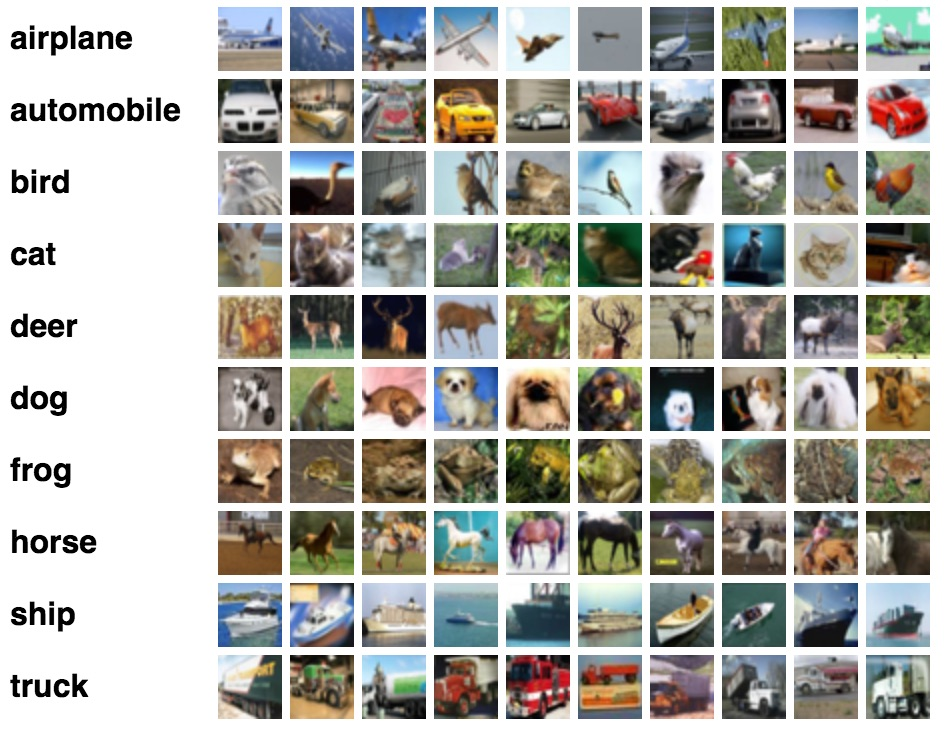

In [2]:
from IPython.display import Image
Image("../images/cifar10.jpg")

<a id="setup"></a>
# 0. Setup

In [1]:
%load_ext sql

/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# Greenplum Database 5.x on GCP - via tunnel
%sql postgresql://gpadmin@localhost:8000/cifar_demo
#%sql postgresql://gpadmin@35.230.53.21:5432/cifar_demo

# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

u'Connected: gpadmin@cifar_demo'

In [3]:
%sql select madlib.version();
#%sql select version();

1 rows affected.


version
"MADlib version: 1.17-dev, git revision: rc/1.16-rc1-63-g7625ae0, cmake configuration time: Tue Jan 14 23:42:21 UTC 2020, build type: RelWithDebInfo, build system: Linux-2.6.32-754.6.3.el6.x86_64, C compiler: gcc 4.4.7, C++ compiler: g++ 4.4.7"


Import libraries and define some params

In [4]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Others needed in this workbook

In [5]:
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

<a id="load_dataset"></a>
# 1.  Load dataset into table

PXF to load iage data

Alternatively just get the dataset from Keras in the usual way

In [ ]:
%%sql
CREATE EXTERNAL TABLE cifar_external_batchsize_500 (
    fullpaths TEXT[], 
    y TEXT[], 
    names TEXT[], 
    x INT[]
) 
LOCATION ('pxf://madlib-datasets/cifar10/?
PROFILE=gs:image&SERVER=gs-aa&BATCH_SIZE=500&STREAM_FRAGMENTS=true') FORMAT 'csv';

CREATE TABLE cifar10_train AS SELECT * FROM cifar_external_batchsize_500;

In [6]:
%sql SELECT COUNT(*) FROM cifar10_train;

1 rows affected.


count
50000


In [6]:
%sql SELECT COUNT(*) FROM cifar10_val;

1 rows affected.


count
10000


<a id="distr"></a>
# 2.  Setup distribution rules and call preprocessor

Get cluster configuration


In [8]:
%%sql
DROP TABLE IF EXISTS host_gpu_mapping_tf;
SELECT * FROM madlib.gpu_configuration('host_gpu_mapping_tf');
SELECT * FROM host_gpu_mapping_tf ORDER BY hostname, gpu_descr;

Done.
1 rows affected.
20 rows affected.


hostname,gpu_descr
phoenix0,"device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
phoenix0,"device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:05.0, compute capability: 6.0"
phoenix0,"device: 2, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:06.0, compute capability: 6.0"
phoenix0,"device: 3, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:07.0, compute capability: 6.0"
phoenix1,"device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
phoenix1,"device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:05.0, compute capability: 6.0"
phoenix1,"device: 2, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:06.0, compute capability: 6.0"
phoenix1,"device: 3, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:07.0, compute capability: 6.0"
phoenix2,"device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
phoenix2,"device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:05.0, compute capability: 6.0"


Build distribution rules table for 4 VMs

In [ ]:
%%sql
DROP TABLE IF EXISTS segments_to_use_4VMs;
CREATE TABLE segments_to_use_4VMs AS
  SELECT DISTINCT dbid, hostname FROM gp_segment_configuration JOIN host_gpu_mapping_tf USING (hostname)
  WHERE role='p' AND content>=0 AND hostname!='phoenix4';
SELECT * FROM segments_to_use_4VMs ORDER BY hostname, dbid;

Build distribution rules table for 2 VMs

In [ ]:
%%sql
DROP TABLE IF EXISTS segments_to_use_2VMs;
CREATE TABLE segments_to_use_2VMs AS
  SELECT DISTINCT dbid, hostname FROM gp_segment_configuration JOIN host_gpu_mapping_tf USING (hostname)
  WHERE role='p' AND content>=0 AND (hostname='phoenix0' OR hostname='phoenix1');
SELECT * FROM segments_to_use_2VMs ORDER BY hostname, dbid;

Build distribution rules table for 1 VMs

In [ ]:
%%sql
DROP TABLE IF EXISTS segments_to_use_1VM;
CREATE TABLE segments_to_use_1VM AS
  SELECT DISTINCT dbid, hostname FROM gp_segment_configuration JOIN host_gpu_mapping_tf USING (hostname)
  WHERE role='p' AND content>=0 AND hostname='phoenix0';
SELECT * FROM segments_to_use_1VM ORDER BY hostname, dbid;

Build distribution rules table for 1 segment

In [26]:
%%sql
SELECT * FROM gp_segment_configuration WHERE role='p' AND hostname='phoenix0' ORDER BY dbid;

5 rows affected.


dbid,content,role,preferred_role,mode,status,port,hostname,address,replication_port
1,-1,p,p,s,u,5432,phoenix0,phoenix0,None
2,0,p,p,c,u,40000,phoenix0,phoenix0,70000
3,1,p,p,c,u,40001,phoenix0,phoenix0,70001
4,2,p,p,c,u,40002,phoenix0,phoenix0,70002
5,3,p,p,c,u,40003,phoenix0,phoenix0,70003


In [27]:
%%sql
DROP TABLE IF EXISTS segments_to_use_1seg;
CREATE TABLE segments_to_use_1seg AS
  SELECT DISTINCT dbid, hostname FROM gp_segment_configuration JOIN host_gpu_mapping_tf USING (hostname)
  WHERE dbid=2;
SELECT * FROM segments_to_use_1seg ORDER BY hostname, dbid;

Done.
1 rows affected.
1 rows affected.


dbid,hostname
2,phoenix0


Training dataset (uses training preprocessor):

In [7]:
%%sql
DROP TABLE IF EXISTS cifar10_train_packed, cifar10_train_packed_summary;

SELECT madlib.training_preprocessor_dl('cifar10_train',        -- Source table
                                       'cifar10_train_packed', -- Output table
                                       'y',                    -- Dependent variable
                                       'x',                    -- Independent variable
                                        NULL,                  -- Buffer size
                                        256.0,                 -- Normalizing constant
                                        NULL,                  -- Number of classes
                                       'segments_to_use_4VMs'  -- Distribution rules
                                        );

SELECT independent_var_shape, dependent_var_shape, buffer_id FROM cifar10_train_packed ORDER BY buffer_id;

Done.
1 rows affected.
16 rows affected.


independent_var_shape,dependent_var_shape,buffer_id
"[3125, 32, 32, 3]","[3125, 10]",0
"[3125, 32, 32, 3]","[3125, 10]",1
"[3125, 32, 32, 3]","[3125, 10]",2
"[3125, 32, 32, 3]","[3125, 10]",3
"[3125, 32, 32, 3]","[3125, 10]",4
"[3125, 32, 32, 3]","[3125, 10]",5
"[3125, 32, 32, 3]","[3125, 10]",6
"[3125, 32, 32, 3]","[3125, 10]",7
"[3125, 32, 32, 3]","[3125, 10]",8
"[3125, 32, 32, 3]","[3125, 10]",9


In [8]:
%%sql
SELECT * FROM cifar10_train_packed_summary;

1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes,distribution_rules,__internal_gpu_config__
cifar10_train,cifar10_train_packed,y,x,smallint,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",3125,256.0,10,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]"


Validation dataset (uses validation preprocessor):

In [9]:
%%sql
DROP TABLE IF EXISTS cifar10_val_packed, cifar10_val_packed_summary;

SELECT madlib.validation_preprocessor_dl('cifar10_val',          -- Source table
                                         'cifar10_val_packed',   -- Output table
                                         'y',                    -- Dependent variable
                                         'x',                    -- Independent variable
                                         'cifar10_train_packed', -- From training preprocessor step
                                         NULL,                   -- Buffer size
                                         'segments_to_use_4VMs'  -- Distribution rules
                                          ); 

SELECT independent_var_shape, dependent_var_shape, buffer_id FROM cifar10_val_packed ORDER BY buffer_id;

Done.
1 rows affected.
16 rows affected.


independent_var_shape,dependent_var_shape,buffer_id
"[625, 32, 32, 3]","[625, 10]",0
"[625, 32, 32, 3]","[625, 10]",1
"[625, 32, 32, 3]","[625, 10]",2
"[625, 32, 32, 3]","[625, 10]",3
"[625, 32, 32, 3]","[625, 10]",4
"[625, 32, 32, 3]","[625, 10]",5
"[625, 32, 32, 3]","[625, 10]",6
"[625, 32, 32, 3]","[625, 10]",7
"[625, 32, 32, 3]","[625, 10]",8
"[625, 32, 32, 3]","[625, 10]",9


In [10]:
%%sql
SELECT * FROM cifar10_val_packed_summary;

1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes,distribution_rules,__internal_gpu_config__
cifar10_val,cifar10_val_packed,y,x,smallint,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",625,256.0,10,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]"


<a id="arch"></a>
# 3. Define and load model architectures

Model architecture from https://keras.io/examples/cifar10_cnn/

In [6]:
num_classes = 10

#to be removed
#do this just to get shape for model architecture 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [7]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [8]:
model1.to_json()

'{"class_name": "Sequential", "keras_version": "2.1.6", "config": [{"class_name": "Conv2D", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "conv2d_1", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "linear", "trainable": true, "data_format": "channels_last", "filters": 32, "padding": "same", "strides": [1, 1], "dilation_rate": [1, 1], "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "batch_input_shape": [null, 32, 32, 3], "use_bias": true, "activity_regularizer": null, "kernel_size": [3, 3]}}, {"class_name": "Activation", "config": {"activation": "relu", "trainable": true, "name": "activation_1"}}, {"class_name": "Conv2D", "config": {"kernel_constraint": null, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed

Model architecture from https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [9]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.3))

model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.4))

model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
__________

In [10]:
model2.to_json()

'{"class_name": "Sequential", "keras_version": "2.1.6", "config": [{"class_name": "Conv2D", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 2.0, "seed": null, "mode": "fan_in"}}, "name": "conv2d_5", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "data_format": "channels_last", "filters": 32, "padding": "same", "strides": [1, 1], "dilation_rate": [1, 1], "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "batch_input_shape": [null, 32, 32, 3], "use_bias": true, "activity_regularizer": null, "kernel_size": [3, 3]}}, {"class_name": "BatchNormalization", "config": {"beta_constraint": null, "gamma_initializer": {"class_name": "Ones", "config": {}}, "moving_mean_initializer": {"class_name": "Zeros", "config": {}}, "name": "batch_normalization_1", "epsilon": 0.001, "trainable": true, "moving_variance_i

Another model architecture from https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [11]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model3.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.3))
model3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.4))
model3.add(Flatten())
model3.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dropout(0.5))
model3.add(Dense(10, activation='softmax'))

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
__________

Load into model architecture table using psycopg2

In [12]:
import psycopg2 as p2
#conn = p2.connect('postgresql://gpadmin@35.239.240.26:5432/madlib')
#conn = p2.connect('postgresql://fmcquillan@localhost:5432/madlib')
conn = p2.connect('postgresql://gpadmin@localhost:8000/cifar_demo')
cur = conn.cursor()

%sql DROP TABLE IF EXISTS model_arch_table_cifar10;
query = "SELECT madlib.load_keras_model('model_arch_table_cifar10', %s, NULL, %s)"
cur.execute(query,[model1.to_json(), "CNN from Keras docs for CIFAR-10"])
conn.commit()

query = "SELECT madlib.load_keras_model('model_arch_table_cifar10', %s, NULL, %s)"
cur.execute(query,[model2.to_json(), "CNN from Jason Brownlee blog post"])
conn.commit()

query = "SELECT madlib.load_keras_model('model_arch_table_cifar10', %s, NULL, %s)"
cur.execute(query,[model3.to_json(), "CNN from Jason Brownlee blog post - no batch normalization"])
conn.commit()

# check model loaded OK
%sql SELECT model_id, name FROM model_arch_table_cifar10 ORDER BY model_id;

Done.
3 rows affected.


model_id,name
1,CNN from Keras docs for CIFAR-10
2,CNN from Jason Brownlee blog post
3,CNN from Jason Brownlee blog post - no batch normalization


<a id="hyperband"></a>
# 4.  Hyperband diagonal

Create tables

In [13]:
%%sql
-- overall results table
DROP TABLE IF EXISTS results_cifar10;
CREATE TABLE results_cifar10 ( 
                      mst_key INTEGER,  -- note not SERIAL
                      model_id INTEGER, 
                      compile_params TEXT,
                      fit_params TEXT, 
                      model_type TEXT, 
                      model_size DOUBLE PRECISION, 
                      metrics_elapsed_time DOUBLE PRECISION[], 
                      metrics_type TEXT[], 
                      training_metrics_final DOUBLE PRECISION, 
                      training_loss_final DOUBLE PRECISION, 
                      training_metrics DOUBLE PRECISION[], 
                      training_loss DOUBLE PRECISION[], 
                      validation_metrics_final DOUBLE PRECISION, 
                      validation_loss_final DOUBLE PRECISION, 
                      validation_metrics DOUBLE PRECISION[], 
                      validation_loss DOUBLE PRECISION[], 
                      model_arch_table TEXT, 
                      num_iterations INTEGER, 
                      start_training_time TIMESTAMP, 
                      end_training_time TIMESTAMP,
                      s INTEGER, 
                      i INTEGER,
                      run_id SERIAL
                     );

-- model selection table
DROP TABLE IF EXISTS mst_table_hb_cifar10;
CREATE TABLE mst_table_hb_cifar10 (
                           mst_key SERIAL, 
                           s INTEGER, -- bracket
                           model_id INTEGER, 
                           compile_params VARCHAR, 
                           fit_params VARCHAR
                          );

-- model selection summary table
DROP TABLE IF EXISTS mst_table_hb_cifar10_summary;
CREATE TABLE mst_table_hb_cifar10_summary (model_arch_table VARCHAR);
INSERT INTO mst_table_hb_cifar10_summary VALUES ('model_arch_table_cifar10');

-- model selection table for diagonal
DROP TABLE IF EXISTS mst_diag_table_hb_cifar10;
CREATE TABLE mst_diag_table_hb_cifar10 (
                           mst_key INTEGER, -- note not SERIAL since this table derived from main model selection table
                           s INTEGER, -- bracket
                           model_id INTEGER, 
                           compile_params VARCHAR, 
                           fit_params VARCHAR
                          );

-- model selection summary table for diagonal
DROP TABLE IF EXISTS mst_diag_table_hb_cifar10_summary;
CREATE TABLE mst_diag_table_hb_cifar10_summary (model_arch_table VARCHAR);
INSERT INTO mst_diag_table_hb_cifar10_summary VALUES ('model_arch_table_cifar10');

Done.
Done.
Done.
Done.
Done.
Done.
1 rows affected.
Done.
Done.
Done.
Done.
1 rows affected.


[]

Generalize table names

In [14]:
results_table = 'results_cifar10'

output_table = 'cifar10_multi_model'
output_table_info = '_'.join([output_table, 'info'])
output_table_summary = '_'.join([output_table, 'summary'])

best_model = 'cifar10_best_model'
best_model_info = '_'.join([best_model, 'info'])
best_model_summary = '_'.join([best_model, 'summary'])


mst_table = 'mst_table_hb_cifar10'
mst_table_summary = '_'.join([mst_table, 'summary'])

mst_diag_table = 'mst_diag_table_hb_cifar10'
mst_diag_table_summary = '_'.join([mst_diag_table, 'summary'])

model_arch_table = 'model_arch_table_cifar10'

Hyperband diagonal logic

In [18]:
import numpy as np
from random import random
from math import log, ceil
from time import time, ctime

class Hyperband_diagonal:
    
    def __init__( self, get_params_function, try_params_function ):
        self.get_params = get_params_function #
        self.try_params = try_params_function

        self.max_iter = 27   # maximum iterations per configuration
        self.eta = 3        # defines downsampling rate (default = 3)
        self.skip_last = 0  # 1 means skip last run in each bracket, 0 means run full bracket

        self.logeta = lambda x: log( x ) / log( self.eta )
        self.s_max = int( self.logeta( self.max_iter ))
        self.B = ( self.s_max + 1 ) * self.max_iter
        
        #echo output
        print ("max_iter = " + str(self.max_iter))
        print ("eta = " + str(self.eta))
        print ("B = " + str(self.s_max+1) + "*max_iter = " + str(self.B))
        print ("skip_last = " + str(self.skip_last))
        
        self.setup_full_schedule()
        self.create_mst_superset()
        
        self.best_loss = np.inf
        self.best_accuracy = 0.0

    # create full Hyperband schedule for all brackets ahead of time
    def setup_full_schedule(self):
        self.n_vals = np.zeros((self.s_max+1, self.s_max+1), dtype=int)
        self.r_vals = np.zeros((self.s_max+1, self.s_max+1), dtype=int)
        sum_leaf_n_i = 0 # count configurations at leaf nodes across all s
        
        print (" ")
        print ("Hyperband brackets")

        # loop through each bracket in reverse order
        for s in reversed(range(self.s_max+1)):
            
            print (" ")
            print ("s=" + str(s))
            print ("n_i      r_i")
            print ("------------")

            n = int(ceil(int(self.B/self.max_iter/(s+1))*self.eta**s)) # initial number of configurations
            r = self.max_iter*self.eta**(-s) # initial number of iterations to run configurations for

            #### Begin Finite Horizon Successive Halving with (n,r)
            for i in range(s+1):
                # n_i configs for r_i iterations
                n_i = n*self.eta**(-i)
                r_i = r*self.eta**(i)

                self.n_vals[s][i] = n_i
                self.r_vals[s][i] = r_i

                print (str(n_i) + "     " + str (r_i))
           
                #### End Finite Horizon Successive Halving with (n,r)
        
    # generate model selection tuples for all brackets
    def create_mst_superset(self):
        
        print (" ")
        print ("Create superset of MSTs for each bracket s")
        
        # get hyper parameter configs for each bracket s
        for s in reversed(range(self.s_max+1)):
            n = int(ceil(int(self.B/self.max_iter/(s+1))*self.eta**s)) # initial number of configurations
            r = self.max_iter*self.eta**(-s) # initial number of iterations to run configurations for

            print (" ")
            print ("s=" + str(s))
            print ("n=" + str(n))
            print ("r=" + str(r))
            print (" ")
            
            # n random configurations for each bracket s
            self.get_params(n, s)
            
            
    # Hyperband diagonal logic
    def run(self):   
        
        print (" ")
        print ("Hyperband diagonal")
        print ("Outer loop on diagonal:")
        
        # outer loop on diagonal
        #for i in range(self.s_max+1):
        for i in range((self.s_max+1) - int(self.skip_last)):
            print (" ")
            print ("i=" + str(i))
    
            # zero out diagonal table
            %sql TRUNCATE TABLE $mst_diag_table
            
            # loop on brackets s desc to create diagonal table
            print ("Loop on s desc to create diagonal table:")
            for s in range(self.s_max, self.s_max-i-1, -1):

                # build up mst table for diagonal
                %sql INSERT INTO $mst_diag_table (SELECT * FROM $mst_table WHERE s=$s);
            
            # first pass
            if i == 0:
                first_pass = True
            else:
                first_pass = False
                
            # multi-model training
            print (" ")
            print ("Try params for i = " + str(i))
            U = self.try_params(i, self.r_vals[self.s_max][i], first_pass) # r_i is the same for all diagonal elements
            
            # loop on brackets s desc to prune model selection table
            # don't need to prune if finished last diagonal
            #if i < (self.s_max):
            if i < (self.s_max - int(self.skip_last)):
                print ("Loop on s desc to prune mst table:")
                for s in range(self.s_max, self.s_max-i-1, -1):
                    
                    # compute number of configs to keep
                    # remember i value is different for each bracket s on the diagonal
                    k = int( self.n_vals[s][s-self.s_max+i] / self.eta)
                    print ("Pruning s = {} with k = {}".format(s, k))

                    # temporarily re-define table names due to weird Python scope issues
                    results_table = 'results_cifar10'

                    output_table = 'cifar10_multi_model'
                    output_table_info = '_'.join([output_table, 'info'])
                    output_table_summary = '_'.join([output_table, 'summary'])

                    mst_table = 'mst_table_hb_cifar10'
                    mst_table_summary = '_'.join([mst_table, 'summary'])

                    mst_diag_table = 'mst_diag_table_hb_cifar10'
                    mst_diag_table_summary = '_'.join([mst_diag_table, 'summary'])

                    model_arch_table = 'model_arch_table_cifar10'
            
                    query = """
                    DELETE FROM {mst_table} WHERE s={s} AND mst_key NOT IN (SELECT {output_table_info}.mst_key FROM {output_table_info} JOIN {mst_table} ON {output_table_info}.mst_key={mst_table}.mst_key WHERE s={s} ORDER BY validation_loss_final ASC LIMIT {k}::INT);
                    """.format(**locals())
                    cur.execute(query)
                    conn.commit()
                    
                    # these were not working so used cursor instead
                    #%sql DELETE FROM $mst_table WHERE s=$s AND mst_key NOT IN (SELECT $output_table_info.mst_key FROM $output_table_info JOIN $mst_table ON $output_table_info.mst_key=$mst_table.mst_key WHERE s=$s ORDER BY validation_loss_final ASC LIMIT $k::INT);
                    #%sql DELETE FROM mst_table_hb_cifar10 WHERE s=1 AND mst_key NOT IN (SELECT cifar10_multi_model_info.mst_key FROM cifar10_multi_model_info JOIN mst_table_hb_cifar10 ON cifar10_multi_model_info.mst_key=mst_table_hb_cifar10.mst_key WHERE s=1 ORDER BY validation_loss_final ASC LIMIT 1);
        
            # keep track of best loss so far and save the model for inference
            # get best loss and accuracy from this diagonal run
            # (need to check if this will work OK if don't evaluate metrics every iteration)
            loss = %sql SELECT validation_loss_final FROM $output_table_info ORDER BY validation_loss_final ASC LIMIT 1;
            accuracy = %sql SELECT validation_metrics_final FROM $output_table_info ORDER BY validation_metrics_final DESC LIMIT 1;
                    
            # save best model based on accuracy (could do loss if you wanted)
            if accuracy > self.best_accuracy:
                
                self.best_accuracy = accuracy
                
                # get best mst_key
                best_mst_key = %sql SELECT mst_key FROM $output_table_info ORDER BY validation_metrics_final DESC LIMIT 1; 
                best_mst_key = best_mst_key.DataFrame().to_numpy()[0][0]

                # save model table (1 row for best model)
                %sql DROP TABLE IF EXISTS $best_model;
                %sql CREATE TABLE $best_model AS SELECT * FROM $output_table WHERE mst_key = $best_mst_key;

                # save info table (1 row for best model)
                %sql DROP TABLE IF EXISTS $best_model_info;
                %sql CREATE TABLE $best_model_info AS SELECT * FROM $output_table_info WHERE mst_key = $best_mst_key;
 
                # save summary table
                %sql DROP TABLE IF EXISTS $best_model_summary;
                %sql CREATE TABLE $best_model_summary AS SELECT * FROM $output_table_summary;
            
            if loss < self.best_loss:
                self.best_loss = loss
                
            print (" ")
            print ("Best validation loss so far = ")
            print (str(loss))
            print ("Best validation accuracy so far = ")
            print (str(accuracy))
            

            
        return

Generate params and insert into MST table.  This version of get_params uses the same compile parameters for all optimizers, and the same compile/fit parameters for all model architectures.  (This may be too restrictive in some cases.)

In [20]:
def get_params(n, s):
    
    from sklearn.model_selection import ParameterSampler
    from scipy.stats.distributions import uniform
    import numpy as np
    
    # model architecture
    model_id = [1,2]

    # compile params
    # loss function
    loss = ['categorical_crossentropy']
    # optimizer
    optimizer = ['sgd', 'adam', 'rmsprop']
    # learning rate (sample on log scale here not in ParameterSampler)
    lr_range = [0.0001, 0.01]
    lr = 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1]), n)
    # metrics
    metrics = ['accuracy']

    # fit params
    # batch size
    batch_size = [32, 64, 128, 256]
    # epochs
    epochs = [5]

    # create random param list
    param_grid = {
        'model_id': model_id,
        'loss': loss,
        'optimizer': optimizer,
        'lr': lr,
        'metrics': metrics,
        'batch_size': batch_size,
        'epochs': epochs
    }
    param_list = list(ParameterSampler(param_grid, n_iter=n))
    
    for params in param_list:

        model_id = str(params.get("model_id"))
        compile_params = "$$loss='" + str(params.get("loss")) + "',optimizer='" + str(params.get("optimizer")) + "(lr=" + str(params.get("lr")) + ")',metrics=['" + str(params.get("metrics")) + "']$$" 
        fit_params = "$$batch_size=" + str(params.get("batch_size")) + ",epochs=" + str(params.get("epochs")) + "$$"  
        row_content = "(" + str(s) + ", " + model_id + ", " + compile_params + ", " + fit_params + ");"
        
        %sql INSERT INTO $mst_table (s, model_id, compile_params, fit_params) VALUES $row_content
    
    return

Generate params and insert into MST table.  This version of get_params allows for more customization by optimizer and model architecture.  This is sort of brute force and can be improved.

In [20]:
def get_params(n, s):
    
    from sklearn.model_selection import ParameterSampler
    from scipy.stats.distributions import uniform
    import numpy as np
    
    # number of samples by optimizer
    #n_adam = int(n/3)
    n_adam = int(n/2)
    #n_rmsprop = int(n/3)
    n_rmsprop = 0
    n_sgd = int(n - n_adam - n_rmsprop)

    # 1) adam
    
    # model architecture
    model_id = [2,3]

    # compile params
    # loss function
    loss = ['categorical_crossentropy']
    # optimizer
    optimizer = ['adam']
    # learning rate (sample on log scale here not in ParameterSampler)
    lr_range = [0.0001, 0.001]
    lr = 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1]), n_adam)
    # metrics
    metrics = ['accuracy']

    # fit params
    # batch size
    batch_size = [128, 256]
    # epochs
    epochs = [5]

    # create random param list
    param_grid = {
        'model_id': model_id,
        'loss': loss,
        'optimizer': optimizer,
        'lr': lr,
        'metrics': metrics,
        'batch_size': batch_size,
        'epochs': epochs
    }
    param_list_adam = list(ParameterSampler(param_grid, n_iter=n_adam))

    # iterate over params
    for params in param_list_adam:

        model_id = str(params.get("model_id"))
        compile_params = "$$loss='" + str(params.get("loss")) + "',optimizer='" + str(params.get("optimizer")) + "(lr=" + str(params.get("lr")) + ")',metrics=['" + str(params.get("metrics")) + "']$$" 
        fit_params = "$$batch_size=" + str(params.get("batch_size")) + ",epochs=" + str(params.get("epochs")) + "$$"  
        row_content = "(" + str(s) + ", " + model_id + ", " + compile_params + ", " + fit_params + ");"
    
        # populate mst table
        %sql INSERT INTO $mst_table (s, model_id, compile_params, fit_params) VALUES $row_content
    
    
    # 2) rmsprop
    
    # model architecture
    model_id = [1,2,3]

    # compile params
    # loss function
    loss = ['categorical_crossentropy']
    # optimizer
    optimizer = ['rmsprop']
    # learning rate (sample on log scale here not in ParameterSampler)
    lr_range = [0.0001, 0.001]
    lr = 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1]), n_rmsprop)
    # decay (sample on log scale here not in ParameterSampler if want multiple values)
    decay = [1e-6]

    # metrics
    metrics = ['accuracy']

    # fit params
    # batch size
    batch_size = [32, 64, 128, 256]
    # epochs
    epochs = [5]

    # create random param list
    param_grid = {
        'model_id': model_id,
        'loss': loss,
        'optimizer': optimizer,
        'lr': lr,
        'decay': decay,
        'metrics': metrics,
        'batch_size': batch_size,
        'epochs': epochs
    }
    param_list_rmsprop = list(ParameterSampler(param_grid, n_iter=n_rmsprop))

    # iterate over params
    for params in param_list_rmsprop:

        model_id = str(params.get("model_id"))
        compile_params = "$$loss='" + str(params.get("loss")) + "',optimizer='" + str(params.get("optimizer")) + "(lr=" + str(params.get("lr")) + ",decay=" + str(params.get("decay")) + ")',metrics=['" + str(params.get("metrics")) + "']$$" 
        fit_params = "$$batch_size=" + str(params.get("batch_size")) + ",epochs=" + str(params.get("epochs")) + "$$"  
        row_content = "(" + str(s) + ", " + model_id + ", " + compile_params + ", " + fit_params + ");"
    
        # populate mst table
        %sql INSERT INTO $mst_table (s, model_id, compile_params, fit_params) VALUES $row_content


    # 3) sgd
    
    # model architecture
    model_id = [2,3]

    # compile params
    # loss function
    loss = ['categorical_crossentropy']
    # optimizer
    optimizer = ['sgd']
    # learning rate (sample on log scale here not in ParameterSampler)
    lr_range = [0.001, 0.005]
    lr = 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1]), n_sgd)
    # momentum (sample on log scale here not in ParameterSampler)
    # recall momentum is an exponentially weighted array
    beta_range = [0.9, 0.95]
    beta = 1.0 - 10**np.random.uniform(np.log10(1.0-beta_range[0]), np.log10(1.0-beta_range[1]), n_sgd)
    # metrics
    metrics = ['accuracy']

    # fit params
    # batch size
    batch_size = [128, 256]
    # epochs
    epochs = [5]

    # create random param list
    param_grid = {
        'model_id': model_id,
        'loss': loss,
        'optimizer': optimizer,
        'lr': lr,
        'beta': beta,
        'metrics': metrics,
        'batch_size': batch_size,
        'epochs': epochs
    }
    param_list_sgd = list(ParameterSampler(param_grid, n_iter=n_sgd))

    # iterate over params
    for params in param_list_sgd:

        model_id = str(params.get("model_id"))
        compile_params = "$$loss='" + str(params.get("loss")) + "',optimizer='" + str(params.get("optimizer")) + "(lr=" + str(params.get("lr")) + ",momentum=" + str(params.get("beta")) + ")',metrics=['" + str(params.get("metrics")) + "']$$" 
        fit_params = "$$batch_size=" + str(params.get("batch_size")) + ",epochs=" + str(params.get("epochs")) + "$$"  
        row_content = "(" + str(s) + ", " + model_id + ", " + compile_params + ", " + fit_params + ");"
    
        # populate mst table
        %sql INSERT INTO $mst_table (s, model_id, compile_params, fit_params) VALUES $row_content

    
    #4) organize mst table

    #down sample
    #%sql DELETE from $mst_table WHERE mst_key NOT IN (SELECT mst_key FROM $mst_table ORDER BY random() LIMIT $n);

    # make mst_keys contiguous
    #%sql ALTER TABLE $mst_table DROP COLUMN mst_key;
    #%sql ALTER TABLE $mst_table ADD COLUMN mst_key SERIAL;
    
    return

Run model hopper for candidates in MST table

In [21]:
def try_params(i, r, first_pass):
    
    # multi-model fit
    if first_pass:
        # cold start
        %sql DROP TABLE IF EXISTS $output_table, $output_table_summary, $output_table_info;
        # passing vars as madlib args does not seem to work
        #%sql SELECT madlib.madlib_keras_fit_multiple_model('cifar10_train_packed', $output_table, $mst_diag_table, $r_i::INT, 0);
        %sql SELECT madlib.madlib_keras_fit_multiple_model('cifar10_train_packed', 'cifar10_multi_model', 'mst_diag_table_hb_cifar10', $r::INT, True, 'cifar10_val_packed',1);

    else:
        # warm start to continue from previous run
        %sql SELECT madlib.madlib_keras_fit_multiple_model('cifar10_train_packed', 'cifar10_multi_model', 'mst_diag_table_hb_cifar10', $r::INT, True, 'cifar10_val_packed', 1, True);

    # save results via temp table
    # add everything from info table
    %sql DROP TABLE IF EXISTS temp_results;
    %sql CREATE TABLE temp_results AS (SELECT * FROM $output_table_info);
    
    # add summary table info and i value (same for each row)
    %sql ALTER TABLE temp_results ADD COLUMN model_arch_table TEXT, ADD COLUMN num_iterations INTEGER, ADD COLUMN start_training_time TIMESTAMP, ADD COLUMN end_training_time TIMESTAMP, ADD COLUMN s INTEGER, ADD COLUMN i INTEGER;
    %sql UPDATE temp_results SET model_arch_table = (SELECT model_arch_table FROM $output_table_summary), num_iterations = (SELECT num_iterations FROM $output_table_summary), start_training_time = (SELECT start_training_time FROM $output_table_summary), end_training_time = (SELECT end_training_time FROM $output_table_summary), i = $i;
    
    # get the s value for each run (not the same for each row since diagonal table crosses multiple brackets)
    %sql UPDATE temp_results SET s = m.s FROM mst_diag_table_hb_cifar10 AS m WHERE m.mst_key = temp_results.mst_key;
    
    # copy temp table into results table
    %sql INSERT INTO $results_table (SELECT * FROM temp_results);

    return

Call Hyperband diagonal

In [22]:
hp = Hyperband_diagonal(get_params, try_params )
results = hp.run()

max_iter = 27
eta = 3
B = 4*max_iter = 108
skip_last = 0
 
Hyperband brackets
 
s=3
n_i      r_i
------------
27     1.0
9.0     3.0
3.0     9.0
1.0     27.0
 
s=2
n_i      r_i
------------
9     3.0
3.0     9.0
1.0     27.0
 
s=1
n_i      r_i
------------
6     9.0
2.0     27.0
 
s=0
n_i      r_i
------------
4     27
 
Create superset of MSTs for each bracket s
 
s=3
n=27
r=1.0
 
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
 
s=2
n=9
r=3.0
 
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 

<a id="plot"></a>
# 5. Review and plot results

In [29]:
%sql SELECT * FROM $results_table ORDER BY validation_loss_final ASC LIMIT 1;

1 rows affected.


mst_key,model_id,compile_params,fit_params,model_type,model_size,metrics_elapsed_time,metrics_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss,model_arch_table,num_iterations,start_training_time,end_training_time,s,i,run_id
45,2,"loss='categorical_crossentropy',optimizer='sgd(lr=0.004501919010538727,momentum=0.9002808952996391)',metrics=['accuracy']","batch_size=256,epochs=5",madlib_keras,2159.70019531,"[121.955986022949, 245.619317054749, 368.365077972412, 490.415205955505, 614.768485069275, 737.048167943954, 860.508330106735, 984.307431936264, 1106.31793498993, 1229.54079914093, 1352.66811394691, 1477.57317709923, 1599.99458003044, 1723.35215711594, 1847.86346912384, 1971.57312297821, 2096.37913298607, 2221.54790210724, 2346.08665895462, 2470.83494997025, 2595.6411960125, 2722.25887513161, 2846.48335313797, 2971.13271403313, 3097.49445009232, 3222.44972395897, 3348.5662779808]",[u'accuracy'],0.941940009594,0.169452220201,"[0.574479997158051, 0.658760011196136, 0.695840001106262, 0.72733998298645, 0.733219981193542, 0.771200001239777, 0.778680026531219, 0.808700025081635, 0.809000015258789, 0.818579971790314, 0.835739970207214, 0.84799998998642, 0.853200018405914, 0.858900010585785, 0.872919976711273, 0.878780007362366, 0.88808000087738, 0.880240023136139, 0.894320011138916, 0.903779983520508, 0.912299990653992, 0.908439993858337, 0.919539988040924, 0.924639999866486, 0.929180026054382, 0.9375, 0.941940009593964]","[1.19219434261322, 0.959131419658661, 0.861107409000397, 0.770956337451935, 0.747268915176392, 0.64410811662674, 0.628470838069916, 0.539423823356628, 0.541868448257446, 0.514527797698975, 0.469026476144791, 0.432008743286133, 0.416983753442764, 0.402583330869675, 0.363078087568283, 0.346161216497421, 0.317243546247482, 0.340911239385605, 0.304346263408661, 0.274338334798813, 0.253901869058609, 0.262585163116455, 0.231020957231522, 0.218931555747986, 0.206650838255882, 0.184870630502701, 0.169452220201492]",0.816399991512,0.580716967583,"[0.565699994564056, 0.641200006008148, 0.674899995326996, 0.704500019550323, 0.708000004291534, 0.740499973297119, 0.739799976348877, 0.766499996185303, 0.762099981307983, 0.76690000295639, 0.780900001525879, 0.785000026226044, 0.785300016403198, 0.79009997844696, 0.79449999332428, 0.795799970626831, 0.802600026130676, 0.792599976062775, 0.798399984836578, 0.807299971580505, 0.810500025749207, 0.801699995994568, 0.805400013923645, 0.811600029468536, 0.810100018978119, 0.813899993896484, 0.816399991512299]","[1.20952260494232, 1.00138294696808, 0.919946014881134, 0.846988558769226, 0.835236310958862, 0.748137712478638, 0.745132148265839, 0.670836567878723, 0.688502311706543, 0.673530399799347, 0.646275579929352, 0.626095473766327, 0.629233837127686, 0.623023450374603, 0.601795375347137, 0.603216171264648, 0.587353229522705, 0.635767936706543, 0.61867493391037, 0.594616591930389, 0.586753845214844, 0.60888147354126, 0.601007521152496, 0.593143999576569, 0.601291477680206, 0.583372294902802, 0.580716967582703]",model_arch_table_cifar10,27,2020-01-23 21:12:04.749779,2020-01-23 22:07:53.819497,0,3,65


In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import defaultdict
import pandas as pd
import seaborn as sns
sns.set_palette(sns.color_palette("hls", 20))
plt.rcParams.update({'font.size': 12})
pd.set_option('display.max_colwidth', -1)

Training dataset

65 rows affected.


<IPython.core.display.Javascript object>


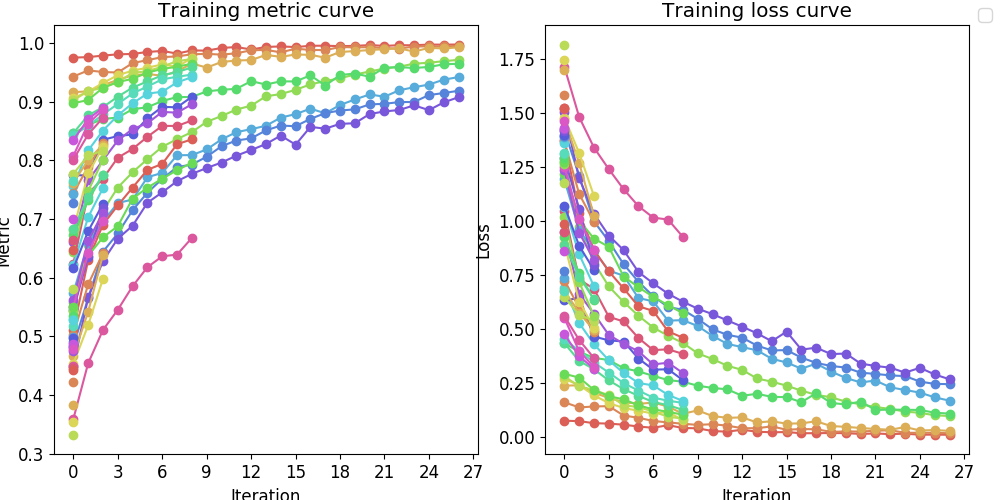

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affecte

In [26]:
#df_results = %sql SELECT * FROM $results_table ORDER BY run_id;
df_results = %sql SELECT * FROM $results_table ORDER BY training_loss_final ASC LIMIT 100;
df_results = df_results.DataFrame()

#set up plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.legend(ncol=4)
fig.tight_layout()

ax_metric = axs[0]
ax_loss = axs[1]

ax_metric.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_metric.set_xlabel('Iteration')
ax_metric.set_ylabel('Metric')
ax_metric.set_title('Training metric curve')

ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_loss.set_xlabel('Iteration')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Training loss curve')

for run_id in df_results['run_id']:
    df_output_info = %sql SELECT training_metrics,training_loss FROM $results_table WHERE run_id = $run_id
    df_output_info = df_output_info.DataFrame()
    training_metrics = df_output_info['training_metrics'][0]
    training_loss = df_output_info['training_loss'][0]
    X = range(len(training_metrics))
    
    ax_metric.plot(X, training_metrics, label=run_id, marker='o')
    ax_loss.plot(X, training_loss, label=run_id, marker='o')

# fig.savefig('./lc_keras_fit.png', dpi = 300)

Validation dataset

65 rows affected.


<IPython.core.display.Javascript object>


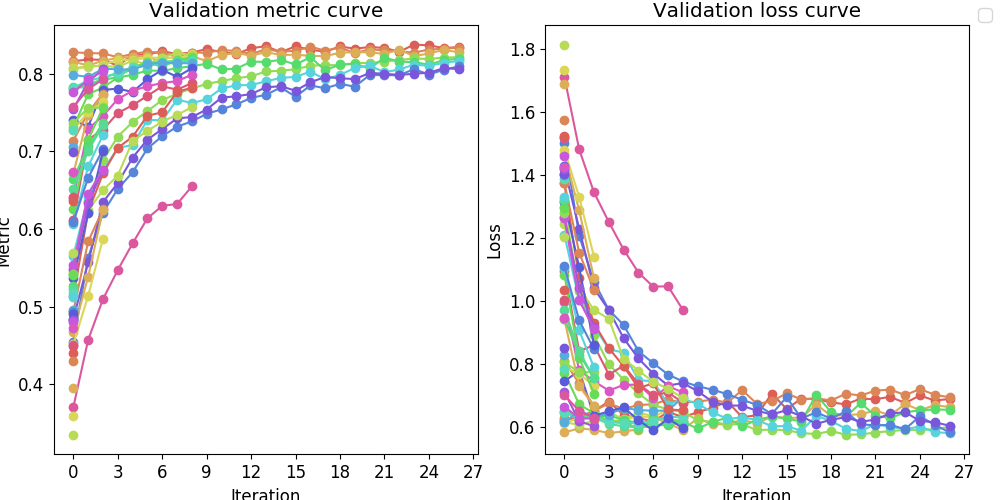

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affecte

In [27]:
#df_results = %sql SELECT * FROM $results_table ORDER BY run_id;
df_results = %sql SELECT * FROM $results_table ORDER BY validation_metrics_final DESC LIMIT 100;
df_results = df_results.DataFrame()

#set up plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.legend(ncol=4)
fig.tight_layout()

ax_metric = axs[0]
ax_loss = axs[1]

ax_metric.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_metric.set_xlabel('Iteration')
ax_metric.set_ylabel('Metric')
ax_metric.set_title('Validation metric curve')

ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_loss.set_xlabel('Iteration')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Validation loss curve')

for run_id in df_results['run_id']:
    df_output_info = %sql SELECT validation_metrics,validation_loss FROM $results_table WHERE run_id = $run_id
    df_output_info = df_output_info.DataFrame()
    validation_metrics = df_output_info['validation_metrics'][0]
    validation_loss = df_output_info['validation_loss'][0]
    X = range(len(validation_metrics))
    
    ax_metric.plot(X, validation_metrics, label=run_id, marker='o')
    ax_loss.plot(X, validation_loss, label=run_id, marker='o')

# fig.savefig('./lc_keras_fit.png', dpi = 300)

<a id="print"></a>
# 6. Print run schedules (display only)

Pretty print reg Hyperband run schedule

In [31]:
import numpy as np
from math import log, ceil

#input
max_iter = 27  # maximum iterations/epochs per configuration
eta = 3  # defines downsampling rate (default=3)
skip_last = 0 # 1 means skip last run in each bracket, 0 means run full bracket

logeta = lambda x: log(x)/log(eta)
s_max = int(logeta(max_iter))  # number of unique executions of Successive Halving (minus one)
B = (s_max+1)*max_iter  # total number of iterations (without reuse) per execution of Succesive Halving (n,r)

#echo output
print ("max_iter = " + str(max_iter))
print ("eta = " + str(eta))
print ("B = " + str(s_max+1) + "*max_iter = " + str(B))
print ("skip_last = " + str(skip_last))

sum_leaf_n_i = 0 # count configurations at leaf nodes across all s

#### Begin Finite Horizon Hyperband outlerloop. Repeat indefinitely.
for s in reversed(range(s_max+1)):
    
    print (" ")
    print ("s=" + str(s))
    print ("n_i      r_i")
    print ("------------")
    counter = 0
    
    n = int(ceil(int(B/max_iter/(s+1))*eta**s)) # initial number of configurations
    r = max_iter*eta**(-s) # initial number of iterations to run configurations for

    #### Begin Finite Horizon Successive Halving with (n,r)
    #T = [ get_random_hyperparameter_configuration() for i in range(n) ] 
    for i in range((s+1) - int(skip_last)):
        # Run each of the n_i configs for r_i iterations and keep best n_i/eta
        n_i = n*eta**(-i)
        r_i = r*eta**(i)
        
        print (str(n_i) + "     " + str (r_i))
        
        # check if leaf node for this s
        if counter == (s-skip_last):
            sum_leaf_n_i += n_i
        counter += 1
        
        #val_losses = [ run_then_return_val_loss(num_iters=r_i,hyperparameters=t) for t in T ]
        #T = [ T[i] for i in argsort(val_losses)[0:int( n_i/eta )] ]
    #### End Finite Horizon Successive Halving with (n,r)

print (" ")
print ("sum of configurations at leaf nodes across all s = " + str(sum_leaf_n_i))
print ("(if have more workers than this, they may not be 100% busy)")

max_iter = 27
eta = 3
B = 4*max_iter = 108
skip_last = 0
 
s=3
n_i      r_i
------------
27     1.0
9.0     3.0
3.0     9.0
1.0     27.0
 
s=2
n_i      r_i
------------
9     3.0
3.0     9.0
1.0     27.0
 
s=1
n_i      r_i
------------
6     9.0
2.0     27.0
 
s=0
n_i      r_i
------------
4     27
 
sum of configurations at leaf nodes across all s = 8.0
(if have more workers than this, they may not be 100% busy)


Pretty print Hyperband diagonal run schedule

In [ ]:
import numpy as np
from math import log, ceil

#input
max_iter = 27  # maximum iterations/epochs per configuration
eta = 3  # defines downsampling rate (default=3)
skip_last = 1 # 1 means skip last run in each bracket, 0 means run full bracket

logeta = lambda x: log(x)/log(eta)
s_max = int(logeta(max_iter))  # number of unique executions of Successive Halving (minus one)
B = (s_max+1)*max_iter  # total number of iterations (without reuse) per execution of Succesive Halving (n,r)

#echo output
print ("echo input:")
print ("max_iter = " + str(max_iter))
print ("eta = " + str(eta))
print ("s_max = " + str(s_max))
print ("B = " + str(s_max+1) + "*max_iter = " + str(B))

print (" ")
print ("initial n, r values for each s:")
initial_n_vals = {}
initial_r_vals = {}
# get hyper parameter configs for each s
for s in reversed(range(s_max+1)):
    
    n = int(ceil(int(B/max_iter/(s+1))*eta**s)) # initial number of configurations
    r = max_iter*eta**(-s) # initial number of iterations to run configurations for
    
    initial_n_vals[s] = n 
    initial_r_vals[s] = r 
    
    print ("s=" + str(s))
    print ("n=" + str(n))
    print ("r=" + str(r))
    print (" ")
    
print ("outer loop on diagonal:")
# outer loop on diagonal
for i in range((s_max+1) - int(skip_last)):
    print (" ")
    print ("i=" + str(i))
    
    print ("inner loop on s desc:")
    # inner loop on s desc
    for s in range(s_max, s_max-i-1, -1):
        n_i = initial_n_vals[s]*eta**(-i+s_max-s)
        r_i = initial_r_vals[s]*eta**(i-s_max+s)
        
        print ("s=" + str(s))
        print ("n_i=" + str(n_i))
        print ("r_i=" + str(r_i))

<a id="predict"></a>
# 7. Inference

Use the best model from the last run.

## 7a. Run predict on the whole validation dataset

In [93]:
%sql SELECT * FROM $best_model_info;

1 rows affected.


mst_key,model_id,compile_params,fit_params,model_type,model_size,metrics_elapsed_time,metrics_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss
6,2,"loss='categorical_crossentropy',optimizer='adam(lr=0.002826545217978097)',metrics=['accuracy']","batch_size=128,epochs=5",madlib_keras,2159.70019531,"[156.498700857162, 314.38369679451, 471.076618909836]",[u'accuracy'],0.89631998539,0.301868826151,"[0.817480027675629, 0.862479984760284, 0.896319985389709]","[0.536632478237152, 0.400230169296265, 0.301868826150894]",0.805899977684,0.613121390343,"[0.764500021934509, 0.788500010967255, 0.805899977684021]","[0.717438697814941, 0.662977695465088, 0.613121390342712]"


In [94]:
best_mst_key = %sql SELECT mst_key FROM $best_model_info; 
best_mst_key = best_mst_key.DataFrame().to_numpy()[0][0]

1 rows affected.


In [95]:
%sql DROP TABLE IF EXISTS cifar10_val_predict;
%sql SELECT madlib.madlib_keras_predict('cifar10_best_model', 'cifar10_val', 'id', 'x', 'cifar10_val_predict', 'response', True, $best_mst_key);
%sql SELECT * FROM cifar10_val_predict ORDER BY id LIMIT 5;

Done.
1 rows affected.
5 rows affected.


id,estimated_y
1,0
2,0
3,0
4,0
5,0


Count missclassifications

In [96]:
%%sql
SELECT COUNT(*) FROM cifar10_val_predict JOIN cifar10_val USING (id) 
WHERE cifar10_val_predict.estimated_y != cifar10_val.y;

1 rows affected.


count
1941


Accuracy

In [97]:
%%sql
SELECT round(count(*)*100.0/10000.0,2) as test_accuracy_percent from
    (select cifar10_val.y as actual, cifar10_val_predict.estimated_y as predicted
     from cifar10_val_predict inner join cifar10_val
     on cifar10_val.id=cifar10_val_predict.id) q
WHERE q.actual=q.predicted;

1 rows affected.


test_accuracy_percent
80.59


## 7b. Select a random image from the validation dataset and run predict

Label map

In [98]:
label_names = {
    0 :"airplane",
    1 :"automobile",
    2 :"bird",
    3:"cat",
    4 :"deer",
    5 :"dog",
    6 :"frog",
    7 :"horse",
    8 :"ship",
    9 :"truck"
}

Pick a random image

In [99]:
%%sql
DROP TABLE IF EXISTS cifar10_val_random;
CREATE TABLE cifar10_val_random AS
    SELECT * FROM cifar10_val ORDER BY random() LIMIT 1;

Done.
1 rows affected.


[]

Predict

In [100]:
%sql DROP TABLE IF EXISTS cifar10_val_random_predict;
%sql SELECT madlib.madlib_keras_predict('cifar10_best_model', 'cifar10_val_random', 'id', 'x', 'cifar10_val_random_predict', 'prob', True, $best_mst_key);
%sql SELECT * FROM cifar10_val_random_predict ;

Done.
1 rows affected.
1 rows affected.


id,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9
9813,7.9166554e-08,0.00038159246,8.776156e-11,1.7702625e-08,1.2219187e-10,8.096258e-10,5.192042e-10,1.5758073e-09,4.106987e-07,0.99961793


Format output and display

In [101]:
%%sql
DROP TABLE IF EXISTS cifar10_val_random_predict_array, cifar10_val_random_predict_array_summary;
SELECT madlib.cols2vec(
    'cifar10_val_random_predict',
    'cifar10_val_random_predict_array',
    '*',
    'id'
);
select * from cifar10_val_random_predict_array;

Done.
1 rows affected.
1 rows affected.


feature_vector
"[7.9166554e-08, 0.00038159246, 8.776156e-11, 1.7702625e-08, 1.2219187e-10, 8.096258e-10, 5.192042e-10, 1.5758073e-09, 4.106987e-07, 0.99961793]"


1 rows affected.
1 rows affected.
 
truck 0.99961793
automobile 0.00038159246
ship 4.106987e-07


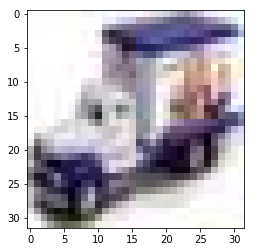

In [102]:
x = %sql SELECT x FROM cifar10_val_random;
x = x.DataFrame().to_numpy()
import numpy as np
from matplotlib.pyplot import imshow
%matplotlib inline
x_np = np.array(x[0][0], dtype=np.uint8)
imshow(x_np)

x = %sql SELECT * FROM cifar10_val_random_predict_array;
x = x.DataFrame().to_numpy()
x = np.array(x[0][0])
top_3_prob_label_indices = x.argsort()[-3:][::-1]
print (" ");
for index in top_3_prob_label_indices:
    print (label_names[index], x[index])